# Fit Spectre XPS

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.optimize import curve_fit
import pandas as pd


plt.rcParams["figure.figsize"] = (10, 7)

# TODO
# * chercher la relation entre la largeur à mi-hauteur d'une gaussienne 
#   et d'une lorentzienne
#   GLS/GLP => http://www.casaxps.com/help_manual/line_shapes.htm

## Fit Functions

### General functions

Gaussian functions

\begin{equation}
    gauss(x, \mu, \sigma) = \frac{1}{\sigma \sqrt{2\pi}} \exp\left(-\frac{(x - \mu)^2}{2 \sigma^2} \right)
\end{equation}

Lorentz function

\begin{equation}
    lorentz(x, x_o, \gamma) = \frac{\gamma \big/ 2\pi}{\left(\gamma \big/ 2\right)^2 + (x - x_o)^2}
\end{equation}

Primitive functions are a gaussian/lorentzian mixing.

In [2]:
def gauss(x, mu=0., sigma=1.):
    """ gaussian funcion of mean mu and standard deviation sigma """
    return 1 / (sigma * np.sqrt(2 * np.pi)) * np.exp(-(x - mu)**2 / (2 * sigma**2))
    
def lorentz(x, xo=0., gamma=1.):
    """ lorentz distribution of with gamma and position xo """
    return gamma / (2 * np.pi) * 1 / ((gamma / 2)**2 + (x - xo)**2)

def mix_g_l(x, xo, fwhm, mixing):
    """ 
    primitive function for the fit. The function is define as :
    
    sum_g_l(x) = mixing * gauss(x) + (1 - mixing) lorentz(x)
    
    WARNING: fwhm for gaussian and lorentz function are note equal
    """
    return mixing * gauss(x, xo, fwhm) + (1 - mixing) * lorentz(x, xo, 1.3*fwhm)

### Functions define from casaXPS

GLS and GLP => http://www.casaxps.com/help_manual/line_shapes.htm

#### GLP, Gaussian Lorentzian product as define in casaXPS

$\alpha$ is the mixing factor.

\begin{equation}
    GLP(x, x_o, \text{fwhm}, \alpha) =
    \exp\left(-\frac{4\ln 2 \; (1 - \alpha) (x - x_o)^2}{\text{fwhm}^2}\right)
    \frac{1}{\displaystyle
        1 + 4 \alpha (x - x_o)^2 \big/ \text{fwhm}^2
    }
\end{equation}

#### GLS, Gaussian Lorentzian sum as define in casaXPS

$\alpha$ is the mixing factor.

\begin{equation}
    GLS(x, x_o, \text{fwhm}, \alpha) =
    (1-\alpha)\,\exp\left(-\frac{4\ln 2 \; (x - x_o)^2}{\text{fwhm}^2}\right)
    +
    \alpha
    \frac{1}{\displaystyle
        1 + 4 (x - x_o)^2 \big/ \text{fwhm}^2 
    }
\end{equation}

In [3]:
def GLP(x, xo, fwhm=1, mixing=.5):
    """ 
    gaussian/lorentzian Product form 
    
    Args:
        x: scalar or array 
        xo (float): position
        fwhm (float): full width at half maximum
        mixing (float): proportion of lorentzian function
    """
    return np.exp(- 4 * np.log(2) * (1 - mixing) * (x - xo)**2 / fwhm**2) / (1 + 4 * mixing * (x - xo)**2 / fwhm**2)
    
def GLS(x, xo, fwhm=1, mixing=.5):
    """
    gaussian/lorentzian sum form 
    
    Args:
        x: scalar or array 
        xo (float): position
        fwhm (float): full width at half maximum
        mixing (float): proportion of lorentzian function
    """
    return (1 - mixing) * np.exp(-4 * np.log(2) * (x - xo)**2 / fwhm**2) + mixing / (1 + 4 * (x - xo)**2 / fwhm**2)

GLS is slightly larger  at the bottom

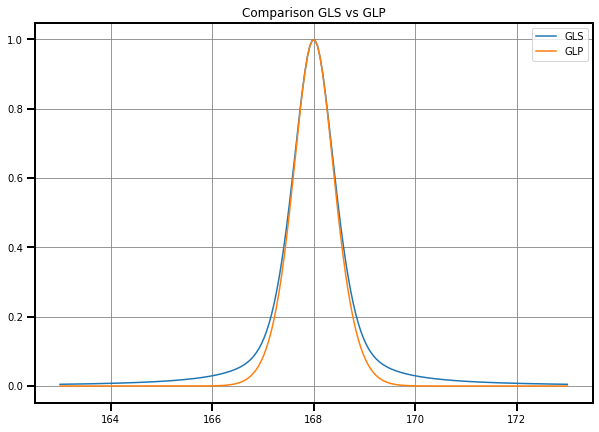

In [4]:
x = np.linspace(163, 173, 200)
plt.plot(x, GLS(x, 168), label="GLS")
plt.plot(x, GLP(x, 168), label="GLP")
plt.title("Comparison GLS vs GLP")
plt.legend()

## Curve fit

* use `curve_fit` form `scipy.optimize`

### Check on toy datas

Make toy data with GLP function plus a random distribution.

In [5]:
x = np.linspace(-2, 2, 100)
xo =0
fwhm = 1
mixing = .5
y = GLP(x, xo, fwhm, mixing)
ye = np.array([yi + 0.1 * np.random.uniform(-yi, yi) for yi in y])
print("xo   = %f\nfwhm = %f\nmix  = %f" % (xo, fwhm, mixing))

xo   = 0.000000
fwhm = 1.000000
mix  = 0.500000


Fit GLP on randomized GLP data.

xo   = 0.000401
fwhm = 0.988661
mix  = 0.545103


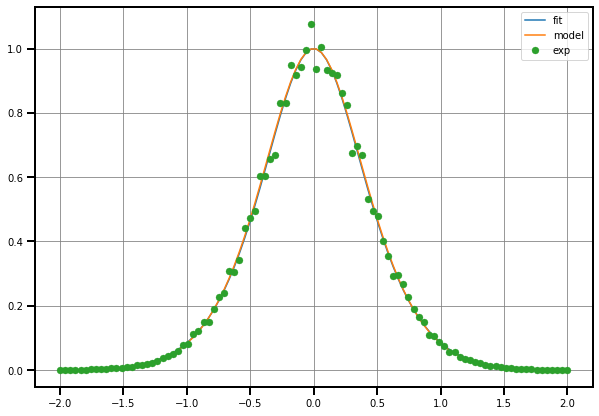

In [6]:
params, pcov = curve_fit(GLP, x, ye)
plt.plot(x, GLP(x, *params), label="fit")
plt.plot(x, y, label="model")
plt.plot(x, ye, "o", label="exp")
plt.legend()
print("xo   = %f\nfwhm = %f\nmix  = %f" % tuple(params))

### Load real datas

In [7]:
df = pd.read_csv("C_1s.csv", index_col=0)
df.head()

,KE,Exp,Comp_1,Comp_2,Comp_3,BG,envelope
BE,,,,,,,
294.824,1026.592,0.0,0.0,0.0,0.0,0.0,0.0
294.724,1024.748,0.0,0.0,0.0,0.0,0.0,0.0
294.624,1030.681,0.0,0.0,0.0,0.0,0.0,0.0
294.524,1020.226,0.0,0.0,0.0,0.0,0.0,0.0
294.424,1029.492,0.0,0.0,0.0,0.0,0.0,0.0


Text(0.5, 1.0, 'XPS plot')

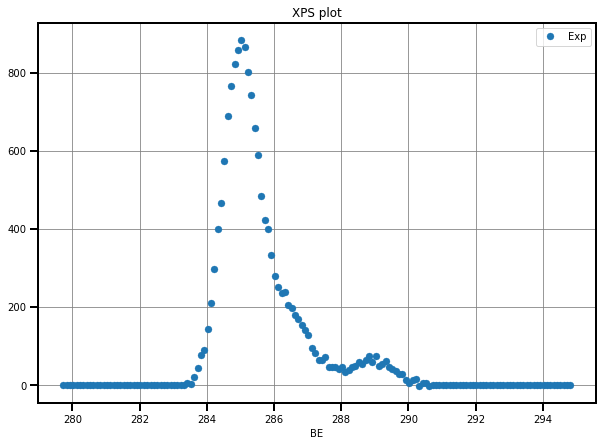

In [8]:
ax = df.plot(kind="line", marker="o", linewidth=0, y="Exp")
ax.set_title("XPS plot")

### Fit a sum of GLS or GLP functions

First define the function for the fit.

In [9]:
def function(x, *param, mixing=.5, basis=GLS):
    """ 
    sum of several primitive functions such as
    
    contaction = sum_i coefs_i * basis(params_i)
    
    args:
        x: float or numpy array of float
        params: list of parameters (magnitude, position) the last one being the full width at half maximum
        mixing: the gaussian / lorentz mixing parameter
        basis: a basis function, GLS or GLP
    """
    
    # check the number of parameters
    nparam = len(param) - 1
    if nparam % 2 != 0:
        raise ValueError("param must be a list of (coef, position) ...")
    
    # fwhm is the last parameter
    fwhm = param[-1]
    
    # compute values
    x = np.array(x)
    values = np.zeros(x.shape)
    for i in range(0, nparam, 2):
        values += param[i] * basis(x, param[i+1], fwhm=fwhm, mixing=mixing)
    
    return values

[888.40704531 285.01692848 150.45996577 286.38879659  54.43679779
 288.93739637   1.17631332]

fit =  888 GLS(285.0) + 150 GLS(286.4) + 54 GLS(288.9)
fwhm =  1.1763133232406064


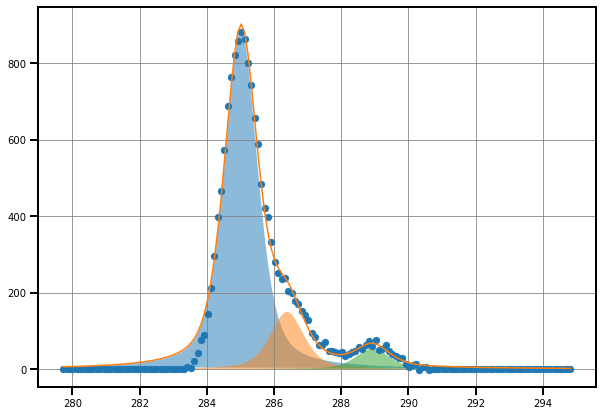

In [19]:
params, popt = curve_fit(
    function,
    xdata=df.index.values, 
    ydata=df.Exp.values,
    p0=(800, 285, 200, 287, 100, 289, 1),
    bounds=(3*[0, 280] + [.8], 3*[4000, 294] + [1.3])
)

print(params)

plt.plot(df.index, df.Exp, "o")
plt.plot(df.index, function(df.index, *params))

line = ""
for i in range(0, len(params) - 2, 2):
    plt.fill(df.index, params[i] * GLS(df.index, params[i+1], fwhm=params[-1], mixing=.5), alpha=.5)
#    line += "%4.f GLS(%4.1f) + " % (params[i], params[i+1])
    line += f"{params[i]:.0f} GLS({params[i + 1]:.1f}) + "
    
print("\nfit = ", line.strip(" +"))
print("fwhm = ", params[-1])
#print(pcov)